# Instance creator utility

data  
|-->info  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    |-->name  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    |-->description  
|-->network  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    |-->nodes  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;        |-->node 0  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;        .  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;        .  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    |-->info  
|-->requests  
|-->fleet  

In [1]:
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os

In [2]:
def TSubElement(parent, tag, attrib={}, text=None, **extra):
    element = ET.SubElement(parent, tag, attrib, **extra)
    if text:
        element.text = text
    return element

### XML tree related functions

In [3]:
def createInfo(root, name='', description=''):
    info = TSubElement(root, 'info')
    _name = TSubElement(info, 'name', text=name)
    _description = TSubElement(info, 'description', text=description)
    return

def createNetwork(root, numDepots, numCustomers, numChargeStations, 
                  cx_low=-1.0, cx_high=1.0, cy_low=-1.0, cy_high=1.0, 
                  request_min=0.01, request_max=0.8,
                  spent_time_min=2.0, spent_time_max=15.0,
                  tw_low_low=600.0, tw_low_high=960.0, tw_min_width= 20.0, tw_max_width=120.0, 
                  travel_time_min=3., travel_time_max=35., 
                  energy_consumption_min=2.0, energy_consumption_max=10.0,
                  max_capacity_charge_stations=4):
    
    network = TSubElement(root, 'network')
    nodes = TSubElement(network, 'nodes') # stores the nodes
    edges = TSubElement(network, 'edges') # stores edges
    info = TSubElement(network, 'info') # stores info about the network
    technologies = TSubElement(network, 'technologies') # stores info about CS techonologies
    
    # depot nodes
    for i in range(numDepots):
        attr = {'id': str(i), 'type': str(0)}
        node = TSubElement(nodes, 'node', attrib=attr)

    # customer nodes
    for i in range(i+1, i+numCustomers+1):
        attr = {'id': str(i), 'type': str(1)}
        node = TSubElement(nodes, 'node', attrib=attr)
        
        request = np.random.uniform(request_min, request_max)
        node.set('request', '{:.2f}'.format(request))
        
        spent_time = np.random.uniform(spent_time_min, spent_time_max)
        node.set('spent_time', '{:.2f}'.format(spent_time))
        
        tw_low = np.random.uniform(tw_low_low, tw_low_high)
        tw_upp = tw_low + np.random.uniform(tw_min_width, tw_max_width)
        node.set('tw_low', '{:.2f}'.format(tw_low))
        node.set('tw_upp', '{:.2f}'.format(tw_upp))

    # CS nodes
    for i in range(i+1, i+numChargeStations+1):
        attr = {'id': str(i), 'type': str(2)}
        node = TSubElement(nodes, 'node', attrib=attr)
        
        technology = np.random.randint(1, 4) # choose among 1, 2 and 3
        node.set('technology', str(technology))
        
        capacity = np.random.randint(1, max_capacity_charge_stations+1)
        node.set('capacity', str(capacity))
    
    # add coordinates (random)
    for node in nodes:
        cx = np.random.uniform(cx_low, cx_high)
        cy = np.random.uniform(cy_low, cy_high)
        node.set('cx', '{:.2f}'.format(cx))
        node.set('cy', '{:.2f}'.format(cy))
        
    # edges
    for i in nodes:
        nodeFrom = TSubElement(edges, 'node_from', attrib={'id': i.get('id')})
        for j in nodes:
            nodeTo = TSubElement(nodeFrom, 'node_to', attrib={'id': j.get('id')})
            
            if i == j:
                travelTime = 0.
                energyConsumption = 0.
            else:
                travelTime = np.random.uniform(travel_time_min, travel_time_max)
                energyConsumption = np.random.uniform(energy_consumption_min, energy_consumption_max)
                
            nodeTo.set('travel_time', '{:.2f}'.format(travelTime))
            nodeTo.set('energy_consumption', '{:.2f}'.format(energyConsumption))
            
    # technologies
    _tech1 = TSubElement(technologies, 'technology', attrib={'type': str(1)})
    _tech2 = TSubElement(technologies, 'technology', attrib={'type': str(2)})
    _tech3 = TSubElement(technologies, 'technology', attrib={'type': str(3)})
    
    tech1 = {'0.0': '0.0', '20.0': '75.0', '50.0': '80.0', '120.0': '100.0'}
    tech2 = {'0.0': '0.0', '15.0': '75.0', '40.0': '80.0', '80.0': '100.0'}
    tech3 = {'0.0': '0.0', '10.0': '75.0', '25.0': '80.0', '40.0': '100.0'}
    
    _tech_list = [_tech1, _tech2, _tech3]
    tech_list = [tech1, tech2, tech3]
    
    for _tech, tech in zip(_tech_list, tech_list):
        for chargingTime, battLevel in tech.items():
            breakPoint = TSubElement(_tech, 'breakpoint')
            breakPoint.set('charging_time', chargingTime)
            breakPoint.set('battery_level', battLevel)
        
def createRequests(root):
    nodes = root.find('network').find('nodes')
    for node in nodes:
        if node.get('type') == '1':
            pass
    return

def createFleet(root, numEV, attrib):
    _fleet = TSubElement(root, 'fleet')
    _numEV = TSubElement(_fleet, 'fleet_size', text=str(numEV))
    _attributes = TSubElement(_fleet, 'vehicle_attributes')
    for attr, val in attrib.items():
        _attr = TSubElement(_attributes, str(attr), text=str(val))
    return

def createTree(numDepots, numCustomers, numChargeStations, numEV, attribsEV):
    dataElement = ET.Element('instance')
    
    infoElement = createInfo(dataElement)
    networkElement = createNetwork(dataElement, numDepots, numCustomers, numChargeStations)
    requestsElement = createRequests(dataElement)
    
    fleetElement = createFleet(dataElement, numEV, attribsEV)
    
    return ET.ElementTree(dataElement)

In [4]:
numDepot = 1
numCustomer = 7
numCS = 2

numEV = 2
attrib = {'max_payload': 2.5, 'max_tour_duration': 250.0, 'battery_capacity':220.0, 
          'alpha_down': 35.0, 'alpha_up':85.}

dataTree = createTree(numDepot, numCustomer, numCS, numEV, attrib)

In [5]:
instanceName = 'd'+str(numDepot)+'c'+str(numCustomer)+'cs'+str(numCS)+'_ev'+str(numEV)
folderPath = '../data/GA_implementation_xml/'+instanceName
filePath = folderPath+'/'+instanceName+'.xml'

try:
    os.mkdir(folderPath)
except FileExistsError:
    pass
print('Saving to:', filePath)

dataTree.write(filePath)

Saving to: ../data/GA_implementation_xml/d1c7cs2_ev2/d1c7cs2_ev2.xml


In [6]:
# usage example
nodes = dataTree.find('network').find('nodes')
edges = dataTree.find('network').find('edges')

f = 0
t = 7

print('travel time from', f, 'to', t, ':', float(edges[f][t].get('travel_time'))) # travel time [f] to [t]
print('energy consumption from', f, 'to', t, ':', float(edges[f][t].get('energy_consumption'))) # energy consumption [f] to [t]

travel time from 0 to 7 : 11.76
energy consumption from 0 to 7 : 9.96


In [7]:
# example of matrices construction
networkSize = len(nodes)

nodes_id = [int(x.get('id')) for x in nodes]
timeMatrix = np.zeros((networkSize, networkSize))
energyMatrix = np.zeros((networkSize, networkSize))
coordinates = {}

for i, nodeFrom in enumerate(edges):
    for j, nodeTo in enumerate(nodeFrom):
        timeMatrix[i][j] = float(nodeTo.get('travel_time'))
        energyMatrix[i][j] = float(nodeTo.get('energy_consumption'))
    coordinates[i] = (float(nodes[i].get('cx')), float(nodes[i].get('cy')))

print('NODES IDSs:\n', nodes_id)
print('RESULTING TIME MATRIX:\n', timeMatrix)
print('RESULTING ENERGY CONSUMPTION MATRIX:\n', energyMatrix)
print('RESULTING NODES COORDINATES:\n',coordinates)

NODES IDSs:
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
RESULTING TIME MATRIX:
 [[ 0.   33.55 13.51 10.43 28.9  13.89 11.45 11.76  4.4  30.98]
 [21.88  0.   28.28 11.75 13.27 23.03 33.01 25.77  6.27 21.48]
 [12.96 24.94  0.   24.8  29.86  5.03  3.39  9.72 34.31 16.99]
 [31.25 29.16  8.42  0.   15.26  6.05  9.52  3.34  7.11 26.19]
 [ 3.79 30.98 30.15 14.4   0.   25.73 18.33 22.72 28.86 11.82]
 [12.98 15.85 13.93 29.79 14.79  0.   16.36  9.36 32.99 15.85]
 [16.11 18.6  21.52 23.9  18.8  29.28  0.    8.03 31.2  10.66]
 [24.07 19.13 28.19  5.36  4.14 20.56 25.61  0.   20.99 33.17]
 [12.92  7.1  27.26 28.64 27.28 11.78 24.57 12.26  0.   22.48]
 [27.82 33.4   9.95 33.73 11.24 21.46 16.84 15.53 20.42  0.  ]]
RESULTING ENERGY CONSUMPTION MATRIX:
 [[0.   9.25 5.04 5.77 3.62 5.67 6.16 9.96 6.12 6.47]
 [4.35 0.   3.67 2.39 3.21 8.24 5.72 5.83 7.8  7.22]
 [4.86 7.96 0.   4.3  7.93 5.   9.19 6.08 6.93 6.52]
 [8.52 7.9  8.19 0.   3.27 8.8  7.28 9.45 6.26 4.74]
 [8.37 4.55 5.34 6.1  0.   2.6  4.93 8.48 6.82 4.96

C:\Users\jpfut\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\jpfut\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


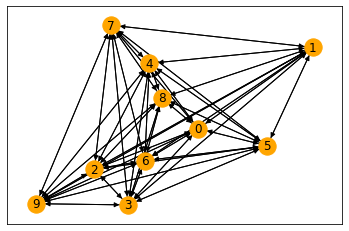

In [8]:
# show a graph of resulting network
G = nx.MultiDiGraph()

G.add_nodes_from(nodes_id)
for i, nodeFrom in enumerate(edges):
    for j, nodeTo in enumerate(nodeFrom):
        G.add_edge(i, j, travel_time=timeMatrix[i][j], energy_consumption=energyMatrix[i][j])

nx.draw_networkx(G, with_labels=True, pos=coordinates, node_color='orange')
plt.show()

In [9]:
G.edges()

OutMultiEdgeDataView([(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)])